# Sparse Neural Additive Models (SNAM)
Xu et al, 2022

In [18]:
import time
import datetime
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
#from torch.optim.lr_scheduler import ExponentialLR
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.datasets import fetch_california_housing
#from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import wandb

from src.utils import data_loader, time_series_splitter
from src.snam.utils import *
from src.snam.snam import *
from src.snam.train import *
from src.snam.plot import *

# Set up

In [2]:
# activate venv & log into wandb
#!source ../ml-env/bin/activate
wandb.login()

## Path to data
root_path = "./data/"
print(root_path)

## setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: m-janyellow. Use `wandb login --relogin` to force relogin


./data/
cuda:0


# Data Loading and Preprocessing

In [3]:
# Load subsample
#subsample_path = '/subsample_processed_scaled.csv'
subsample_path = '/subsample_processed_scaled_1000.csv'
fullsample_path = '/data_processed_scaled.csv'

In [8]:
#subsample = load_data(subsample_path, pickle=False)
#X_train, X_valid, X_test, y_train, y_valid, y_test = load_data(subsample_large, pickle=False)
#print(f'Start of training set: {X_train.index.min()}')
#print(f'End of training set: {X_train.index.max()}')
#print(f'Start of valid set: {X_valid.index.min()}')
#print(f'End of valid set: {X_valid.index.max()}')

# Model & Train

### Train functions

In [9]:
## TO-DO: What exactly happens here?? Where is group lasso? introduce early stopping!

#from torch.optim.lr_scheduler import ExponentialLR

def train_sub(trainloader, testloader,n_features, model, optimizer,max_epoch,
          torch_seed=0, test=False, lbd=0.1, MSE=False):
    
    print("################################## START OF TRAINING ##################################")
    n_layer=0
    for name, param in model.named_parameters():
        if 'feature_nns.0' in name and 'weight' in name:
            n_layer+=1
    
    model.train()
    
    if MSE==True:
      criterion=torch.nn.MSELoss()
    else:
      criterion=torch.nn.CrossEntropyLoss()
    
    # save model and loss metrics
    save_dir = "./models/SNAM/"
    epoch_train_loss_history = []
    epoch_test_loss_history = []
    
    # adaptive lr
    #scheduler = ExponentialLR(optimizer, gamma=0.6)
    
    early_stopping = EarlyStopping(tolerance=2, min_delta=0)
    
    for epoch in range(max_epoch):
        if (epoch)%5==0:
            print(f"##### Training Epoch Nr: {epoch} started ####")
            print("Early stopping counter: ", early_stopping.counter)
        f_out_tr = []                 # train feature outputs
        total_batch_loss=0
        tr_correct, tr_total = 0, 0
        
        for idx1, (inputs, targets) in tqdm(enumerate(trainloader)): 
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs, f_out_tr_temp = model(inputs)[0],model(inputs)[1].detach().cpu().numpy()
            f_out_tr.append(f_out_tr_temp)
            loss=criterion(outputs, targets)
            total_batch_loss += loss.item()

            if MSE == False:
                tr_correct += (torch.argmax(outputs, axis=1) == targets).sum().item()
                tr_total += len(targets)      
            #%%%%%%%%%%%add regularization%%%%%%%%%%%#
            for ind in range(n_features):
                count=1
                reg_loss = torch.tensor(0).float().to(device)
                for name, param in model.named_parameters():                        
                    if 'weight' in name and name.find('feature_nns.'+str(ind)) == 0: 
                        if  count == n_layer: 
                            reg_loss+=groupl1(param.T) 
                        count+=1
                loss += lbd*torch.sqrt(reg_loss)
            loss.backward()
            optimizer.step()
        #if epoch%10==0:
        #    scheduler.step()
        #    for g in optimizer.param_groups:
        #        wandb.log({"current_lr" : g['lr']})


        if test==True:
            model.eval()
            test_loss = 0
            test_correct, test_total = 0, 0
            with torch.no_grad():
                for idx2, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs, f_out_te = model(inputs)[0], model(inputs)[1].detach().cpu().numpy()
                    test_loss += criterion(outputs, targets).item()
                    if MSE == False:
                        test_correct += (torch.argmax(outputs, axis=1) == targets).sum().item()
                        test_total += len(targets)
                test_loss = test_loss/(idx2+1)
                if (epoch+1)%10==0:
                    print(f"test loss : {test_loss}")

        
        if (epoch+1)%10==0:
            if MSE == False:
                print('epoch: ', epoch+1, 'Loss train: ', total_batch_loss/(idx1+1), 'ACC train: ', 100*(tr_correct/tr_total))
                print('Loss test: ', test_loss, 'ACC test: ', 100*(test_correct/test_total))
            else:
                print('epoch: ', epoch+1, 'Loss train: ', total_batch_loss/(idx1+1), 'Loss test: ', test_loss)
                # log metric to tensorboard
                #writer.add_scalar("Train Loss", total_batch_loss/(idx1+1), epoch)
                #writer.add_scalar('Loss test: ', test_loss, epoch)
        wandb.log({"Train Loss" : total_batch_loss/(idx1+1),
                           'Loss test: ' : test_loss})
        # save metrics to list for plotting
        epoch_train_loss_history.append(total_batch_loss/(idx1+1))
        epoch_test_loss_history.append(test_loss)
         
        # save model
        torch.save(model,  save_dir+'model_87.pth') # wandb run id
        
        # early stopping
        early_stopping(total_batch_loss, test_loss)
        
        if early_stopping.early_stop:
          print("Early stopping at epoch:", epoch)
          break
       
    if MSE == False:
        return [100*(test_correct/test_total), test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)), model]
    
    return [test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)), model, epoch_train_loss_history, epoch_test_loss_history]

In [10]:
def predict_and_evaluate_model(model, testloader, run_id=None, load=False, wandb_log=True):
    if load:
        model = torch.load('./models/model_'+str(run_id)+'.pth')
    model.eval()
    #model.to('cpu')
    with torch.no_grad():
        for idx2, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device).reshape(-1) #.detach().cpu().numpy()
            outputs, f_out_te = model(inputs)[0].detach().cpu().numpy(), model(inputs)[1].detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
        # Calculate Test metrics: MAE, MSE, RMSE:
        rmse = np.sqrt(((targets - outputs)**2).mean())
        mae = mean_absolute_error(targets, outputs)
        mse = mean_squared_error(targets, outputs)
        if wandb_log:
            wandb.log({"rmse_test" : rmse, "mse_test" : mse, "mae_test" : mae})
    return rmse, mae, mse, outputs, targets, f_out_te

In [11]:
def simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features, output_size,
             opti_name, MSE=False,
             seed=1, RFM=False, pyramid=False):

    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # start wandb run
    wandb.init(project="interpretable-ml", group="snam-studies")

    print('training with lbd: ', lbd)
    wandb.log({"learning_rate" : lr, "optimizer" : opti_name, "n_features" : n_features,
               "max_epochs" : max_epoch})
    #print(device)

    #if loaded:
    #    model = model
    if pyramid == True:
        if RFM == True:
            model = RF_Net(NAM(n_features, output_size, PyramidNet, seed=1), n_features).to(device)
            print(f"Training on: {device}") 
        else: 
            model = NAM(n_features, output_size, PyramidNet, seed=1).to(device) #, MSE=MSE
            print(f"Training on: {device}")
    else:
        if RFM == True:
            model = RF_Net(NAM(n_features, output_size, SampleNet,seed=1), n_features).to(device)
            print(f"Training on: {device}") 
        else: 
            model = NAM(n_features, output_size, SampleNet,seed=1).to(device) #, MSE=MSE
            print(f"Training on: {device}")

    if opti_name=='SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)
        train_func=train_sub
    elif opti_name=='Adam': 
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        train_func=train_sub
    else:
        print('wrong name. Pls enter one of them: SGD, ADAM, prox.')
        
    result = train_func(trainloader, testloader, n_features, model, optimizer, max_epoch, torch_seed=0, test=True, lbd=lbd, MSE=MSE) #0.8


    return result

### use utils!

In [5]:
##### Train pipeline

# load and prepare data
data = data_loader(root_path, subsample_path, pickle=False)
X_train, X_valid, X_test, y_train, y_valid, y_test = time_series_splitter(data)
trainloader, testloader, output_size = data_totensor(X_train, X_valid, y_train, y_valid)

# def hyperparams
lbd, lr, max_epoch, MSE, n_features, opti_name, pyramid, adaptive_lr = 1, 1e-3, int(10), True, X_train.shape[1], 'Adam', False, True
run_id = '100'
save_dir = './models/snam/'

# compile model
model, optimizer = compile_model(lbd, lr, n_features, output_size, opti_name, device, pyramid)

# fit model
[test_loss, f_out_tr, f_out_te, model, train_loss_history, test_loss_history] = fit_model(trainloader, testloader, n_features, model, optimizer, device, max_epoch, 
                                                                                          run_id, torch_seed=0, test=True, MSE=MSE, save_dir=save_dir, 
                                                                                          adaptive_lr=adaptive_lr)

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], y_train, plot=True)
print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('test loss: ', test_loss)()

<class 'pandas.core.frame.DataFrame'>


current_lr,▁
learning_rate,▁
max_epochs,▁
n_features,▁
current_lr,0.001
learning_rate,0.001
max_epochs,10
n_features,67
optimizer,Adam


Training on: cuda:0
################################## START OF TRAINING ##################################
##### Training Epoch Nr: 0 started ####


252it [00:33,  7.56it/s]
252it [00:32,  7.85it/s]
252it [00:32,  7.85it/s]
252it [00:32,  7.86it/s]
252it [00:31,  7.90it/s]


##### Training Epoch Nr: 5 started ####


252it [00:32,  7.83it/s]
252it [00:32,  7.81it/s]
252it [00:32,  7.84it/s]
252it [00:31,  7.90it/s]
252it [00:32,  7.85it/s]


test loss : 0.014780213832165356
epoch:  10 Loss train:  0.012602065507847343 Loss test:  0.014780213832165356
333.5699324607849
f_tr_out:  [[-1.75431126e-07]
 [-3.16343375e-07]
 [-6.08305584e-07]
 [ 9.30362773e-07]
 [ 4.71916941e-08]
 [-1.48696969e-07]
 [ 7.05992534e-07]
 [-4.92674815e-07]
 [-6.49370691e-07]
 [-5.05755565e-07]
 [-4.33694879e-07]
 [ 1.20315434e-07]
 [-9.08763411e-08]
 [-1.79228834e-06]
 [-4.15836951e-07]
 [ 1.15445994e-06]
 [ 1.49373795e-06]
 [-9.01809130e-07]
 [-8.39666086e-07]
 [-5.59194746e-07]
 [ 3.10103314e-06]
 [ 1.30985359e-06]
 [ 1.99040483e-06]
 [-8.33934848e-07]
 [ 2.72490013e-07]
 [-1.82626889e-06]
 [ 1.15252010e-06]
 [ 2.13017103e-07]
 [-4.07582945e-07]
 [ 1.69091493e-07]
 [-2.79095332e-07]
 [-4.10354858e-07]
 [-1.00979707e-06]
 [ 2.12846899e-07]
 [ 1.17939089e-06]
 [-2.08048760e-07]
 [-1.18367552e-06]
 [-2.07465678e-06]
 [-2.36235337e-06]
 [ 1.00847149e-06]
 [ 3.76491869e-07]
 [-3.78865508e-07]
 [-2.98584337e-06]
 [ 1.03577101e-07]
 [-2.03666659e-07]
 [ 5.

/pfs/data5/home/kit/stud/uvnyg/seminar-interpretable-ml/src/snam/train.py:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return [test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)),


NameError: name 'time_spent' is not defined

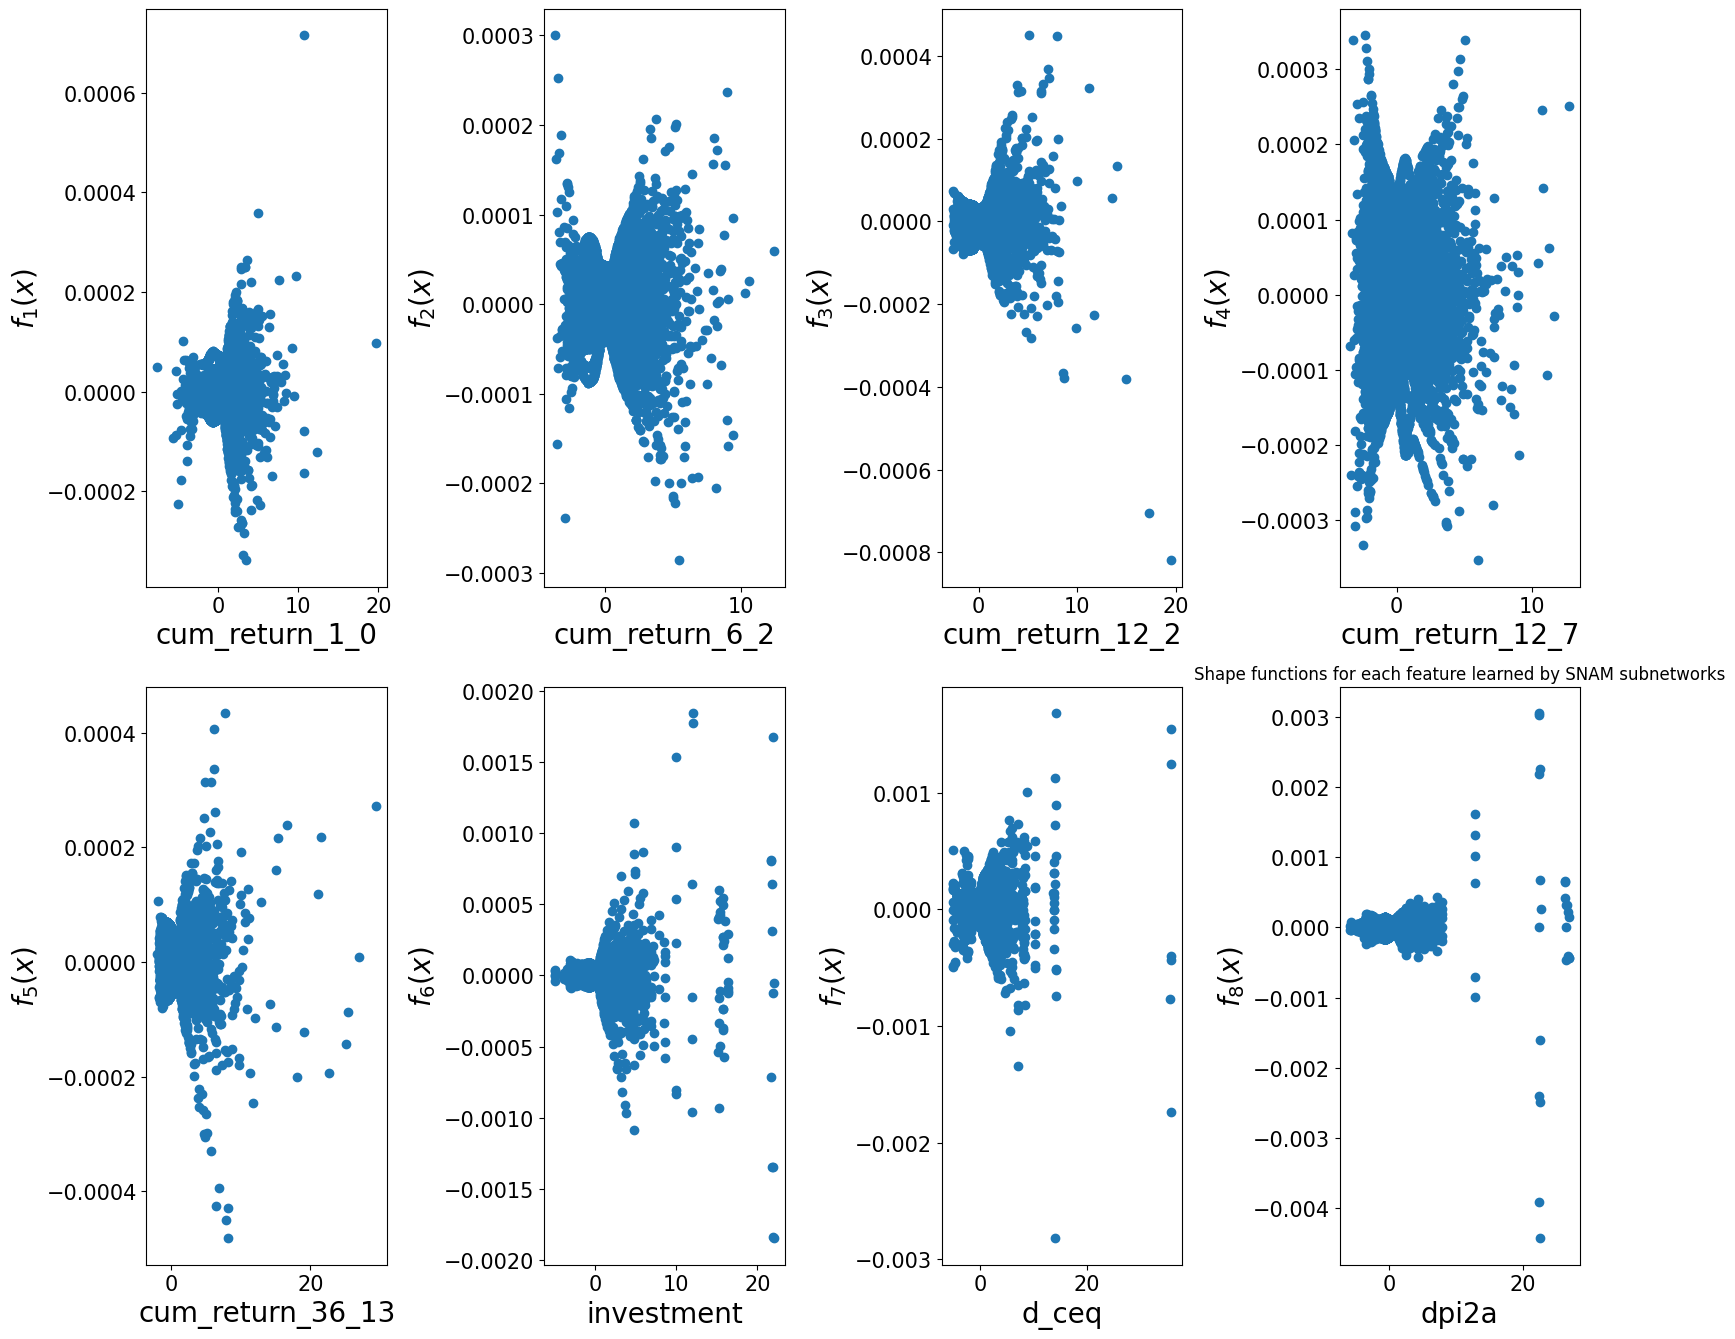

In [21]:
plot_shape_functions(X_train, n_features, f_out_tr, nrows=2, ncols=4, save=True, run_id=run_id)

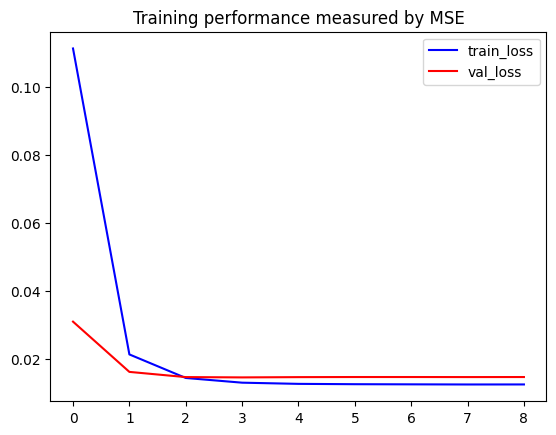

In [24]:
#plt.style.use("seaborn")
plt.title('Training performance measured by MSE')
plt.plot(train_loss_history[1:], c='b', label='train_loss')
plt.plot(test_loss_history[1:], c='r', label='val_loss')
plt.legend()
#plt.savefig('train_history_113')

## Other models (l1-SVM, Lasso, etc.)

#### Regular LASSO

In [ ]:
#data_name = 'data_rg'
#[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))
start = time.time()

clf = Lasso(alpha=0.5)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_valid)
time_spent =  time.time()-start 

#iden_loss = iden_errorML(X_train, clf.coef_, features, plot=True)
print('f_train_out: ', clf.coef_)
print('time spent: ', time_spent, ' sec')
print('test loss: ', np.mean((y_test_pred-y_valid)**2))
print('precision: ', precision_score(true_feature,abs(clf.coef_)>0.01))
print('recall: ', recall_score(true_feature,abs(clf.coef_)>0.01))
#print('iden error: ', iden_loss)

f_train_out:  [ 0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0.  0. -0. -0. -0. -0. -0.  0. -0.  0. -0.  0.  0. -0.  0.  0.  0. -0.
 -0. -0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0. -0.  0.  0. -0. -0.
 -0.  0. -0. -0. -0. -0.  0.  0. -0.  0.  0. -0.  0.]
time spent:  0.1561298370361328  sec
test loss:  0.010845024276192229


NameError: ignored

In [ ]:
##%%save
# f = open(path+"plot_synRG_lasso.pkl","wb")
# pickle.dump([clf.coef_, clf], f)
# f.close()

# ##%%load
[clf.coef_, clf] = \
pickle.load(open(path+"plot_synRG_lasso.pkl", "rb"))

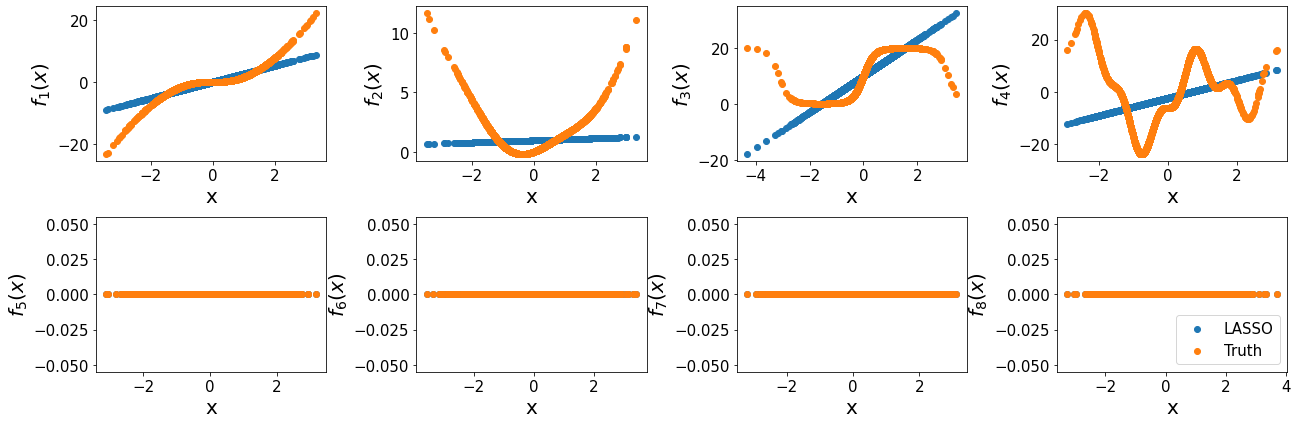

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))

i = 0
for row in axes:
    for col in row:
        if i < len(features):
            f_i = features[i](X_train[:, i])
        else: 
            f_i = np.zeros_like(X_train[:, i])
        f_i_hat = X_train[:, i]*clf.coef_[i]
        c_i=np.mean(f_i_hat-f_i) 
        col.scatter(X_train[:, i], f_i_hat-c_i, label='LASSO')
        col.scatter(X_train[:, i], f_i, label='Truth')
        if i == 7:
            col.legend(fontsize='15', loc=4)
        col.xaxis.set_tick_params(labelsize=15)
        col.yaxis.set_tick_params(labelsize=15)
        col.set_xlabel('x', fontsize='20')
        col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
        i += 1

fig.tight_layout()
fig.savefig(path+'plot_synRG_lasso.pdf', bbox_inches='tight')
plt.show()        

### With selected features

In [16]:
## best features used by freyberger et al:
features_freyberger = ['d_shrout', 'd_so', 'investment', 'lme', 'lturnover', 
                       'pm_adj', 'cum_return_1_0', 'cum_return_12_2', 'cum_return_12_7', 
                       'rel_to_high_price', 'roc','suv', 'total_vol','TARGET']
features_rf = ['d_shrout', 'roe', 'oa', 'free_cf', 'nop', 'dpi2a', 'rna', 'ato', 'd_dgm_dsales', 'roc', 'ipm', 'spread_mean', 'dto', 'suv', 'TARGET']
features_ae = ['e2p', 'beme', 'cum_return_12_2', 'cum_return_12_7', 'mm_sin', 'mm_cos', 'yy', 'dpi2a', 'ret', 'total_vol', 'noa', 'std_volume', 'dto', 'cto', 'TARGET']

In [14]:
print(len(features_rf), " - ", len(features_ae), " - ", len(features_freyberger))

15  -  15  -  14


In [10]:
rmse, mae, mse, outputs, targets, f_te = predict_and_evaluate_model(model, testloader)
print(f'Test performance: RMSE: {rmse}, MAE: {mae}, MSE: {mse}')

NameError: name 'predict_and_evaluate_model' is not defined

### Try reload and predict again

In [35]:
saved_model = torch.load('./models/model_60.pth')

In [39]:
rmse, mae, mse, outputs, targets, f_te = predict_and_evaluate_model(saved_model, testloader, wandb_log=False)
print(f'Test performance: RMSE: {rmse}, MAE: {mae}, MSE: {mse}')

Test performance: RMSE: 0.2081463783979416, MAE: 0.130947083234787, MSE: 0.04330037906765938


In [27]:
### Helper method to visualize prediction vs true values
import random
#plt.style.use("seaborn")

permnos_total = X_train.index.droplevel(['permno'])

def visualize_sample_prediction(y_test, y_pred):
    # Picks a random stock, to visualize its real returns 
    # against the predicted returns
    sample_permno = random.choice(permnos_total)
    ## delete:
    #sample_permno = 51625
    #sample_test_y = y_test.xs(sample_permno, level='permno')
    idx = X_valid.index.droplevel(['permno'])
    #sample_test_idx = sample_test_y.index.get_level_values('date')
    #print(len(idx))
    #y_pred = pd.Series(y_pred, index=y_test.index)
    #sample_pred = y_pred.xs(sample_permno, level='permno')
    print(len(y_test))
    fig,ax=plt.subplots(figsize=(18,6))

    ax.scatter(x=idx, y= y_valid, color='r')
    ax.scatter(x=idx, y= y_pred, color='b')
    plt.title(f'Stock nr {sample_permno} predicted returns (blue) vs actual returns (red)')
    plt.show()

In [ ]:
visualize_sample_prediction()

#### Training with samplenet as subnets #### 

In [ ]:
### TRAINING WITH SAMPLENET AS SUBNETWORKS ###

lbd, lr, max_epoch, MSE, n_features = 2, 5e-3, int(100), True, X_train.shape[1] # lbd = lambda for regularization
trainloader, testloader, output_size = data_totensor(X_train, X_valid, y_train, y_valid, batch_size=256, MSE=MSE)

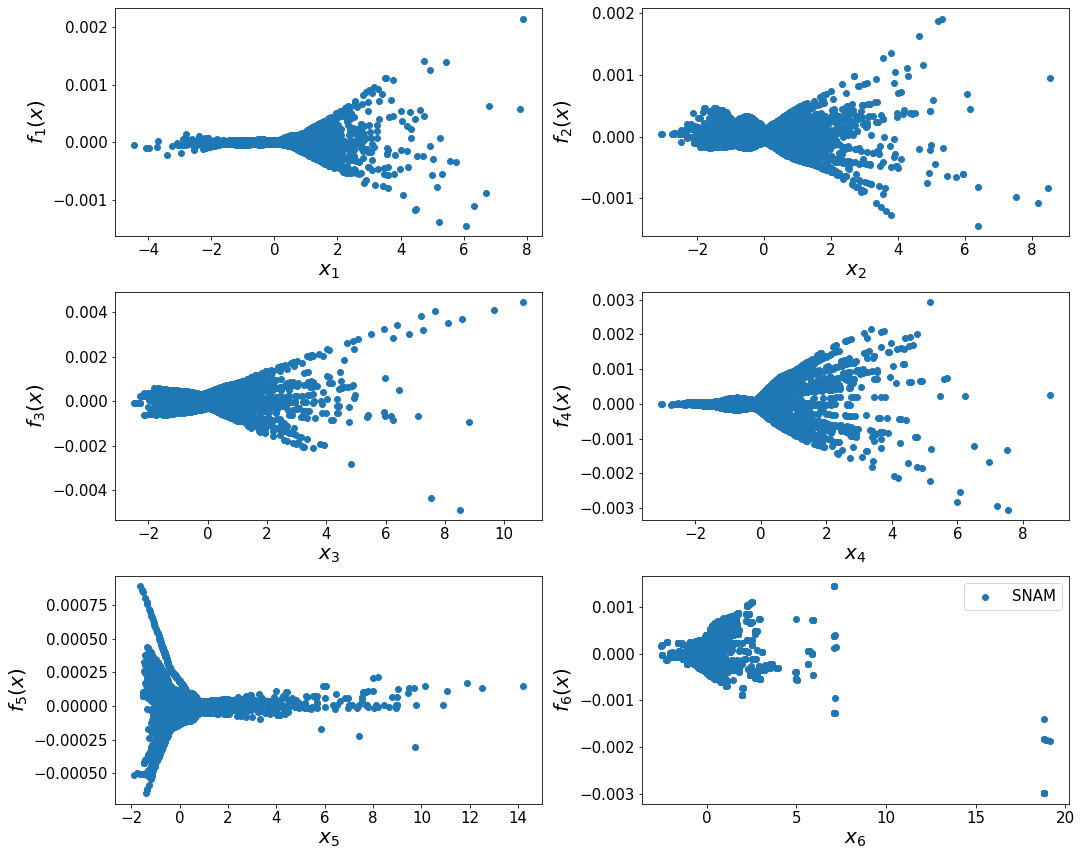

In [43]:
plot_shape_functions(f_out_tr, save=True, run_id=69)

In [ ]:
##%%save
f = open(path+"plot_synRG_snam.pkl","wb")
pickle.dump([test_loss, f_out_tr, f_out_te, model], f)
f.close()

# ##%%load
#[test_loss, f_out_tr, f_out_te, model] = \
#pickle.load(open(path+"plot_synRG_snam.pkl", "rb"))

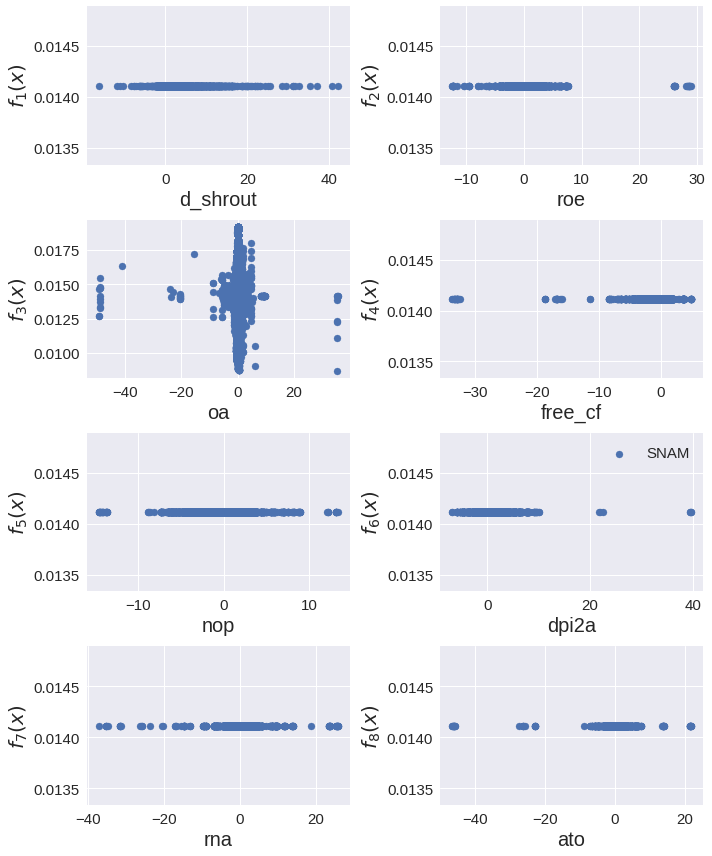

In [150]:
plot_shape_functions(f_out_tr, save=True)

In [28]:
#feature_names = ch_data.feature_names
#features = y_train

def plot_shape_functions(f_out_tr, save=False, run_id=""):
    feature_names = X_train.columns
    # Plot shape functions
    f_tr = f_out_tr
    for i in range(8):
        if i < y_train.shape[0]:
            f_i = y_train.to_numpy().reshape(-1,1) #if y is pd.series
        else: f_i = np.zeros_like(X_train[:, i])
        #print(f_i.shape, "-", f_tr.shape)
        c_i=np.mean(f_tr[:,[i]]-f_i)

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 12))

    i = 0
    for row in axes:
        for col in row:
            if i < y_train.shape[0]:
                f_i = y_train.to_numpy().reshape(-1,1) #if y is pd.series
            else: 
                f_i = np.zeros_like(X_train[:, i])
            c_i=np.mean(f_tr[:,[i]]-f_i) 
            col.scatter(X_train.iloc[:, i], f_tr[:, [i]]-c_i, label='SNAM')
            #col.scatter(X_train, features[i](X_train))
            if i == 5:
                col.legend(fontsize='15')
            col.xaxis.set_tick_params(labelsize=15)
            col.yaxis.set_tick_params(labelsize=15)
            col.set_xlabel(f'{feature_names[i]}', fontsize='20')
            col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
            i += 1

    fig.tight_layout()
    if save:
        fig.savefig(path+'shape_functions_snam_'+str(run_id)+'.png', bbox_inches='tight')
    plt.show()  

#### Training with Pyramidnet as Subnetworks

In [17]:
### TRAINING WITH Pyramidnet AS SUBNETWORKS ###

lbd, lr, max_epoch, MSE, n_features = 2, 5e-3, int(100), True, X_train.shape[1] # what is lbd??
trainloader, testloader, output_size = data_totensor(X_train, X_valid, y_train, y_valid, batch_size=256, MSE=MSE)

start = time.time()
[test_loss, f_out_tr_2, f_out_te, model, train_loss_history, test_loss_history] = simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features=n_features, output_size=1, opti_name='Adam', 
                    MSE=MSE, pyramid=True)
time_spent =  time.time()-start 

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], features, plot=True)
print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('time spent: ', time_spent, ' sec')
print('test loss: ', test_loss)

NameError: name 'X_train' is not defined

In [94]:
print(train_loss_history)

[0.7453324684729943]


## California housing

In [13]:
from sklearn.model_selection import train_test_split
ch_data = sklearn.datasets.fetch_california_housing()

X = ch_data.data
y = ch_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
print(X_train.shape, X_test.shape)

(16512, 8) (4128, 8)


In [15]:
#### utilsss!!!
def data_totensor(X_train, X_test, y_train, y_test, batch_size = 256, batch_size_test=1000,save=False, MSE=True):
    
    #%% separate data into three parts: train, validation(?) and test. 
    if MSE: 
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)
        D_out = 1
    else:
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).long()
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).long()
        D_out = 2

    Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=False)
    Test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    testloader = DataLoader(dataset=Test_dataset, batch_size=batch_size_test, shuffle=False)
    
    if save== True:
        f = open(path+"data/p2_data.pkl","wb")
        pickle.dump([trainloader, testloader, D_out], f)
        f.close()
    
    return trainloader, testloader, D_out 

In [46]:
### TRAINING WITH SampleNet AS SUBNETWORKS ###

lbd, lr, max_epoch, MSE, n_features = 1, 10e-5, int(100), True, X_train.shape[1] # lambda
trainloader, testloader, output_size = data_totensor(X_train, X_test, y_train, y_test, batch_size=256, MSE=MSE)

start = time.time()
[test_loss, f_out_tr, f_out_te, model, train_loss_history, test_loss_history] = simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features=n_features, output_size=1, opti_name='Adam', 
                    MSE=MSE)
time_spent =  time.time()-start 

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], features, plot=True)
print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('time spent: ', time_spent, ' sec')
print('test loss: ', test_loss)

Loss test:,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁
max_epochs,▁
n_features,▁
Loss test:,0.53314
Train Loss,0.54203
learning_rate,0.0001
max_epochs,50
n_features,8
optimizer,Adam


training with lbd:  1
Training on: cuda:0
################################## START OF TRAINING ##################################
##### Training Epoch Nr: 0 started ####
Early stopping counter:  0


65it [00:00, 87.50it/s]
65it [00:00, 88.23it/s]
65it [00:00, 87.35it/s]
65it [00:00, 67.79it/s]
65it [00:00, 87.81it/s]


##### Training Epoch Nr: 5 started ####
Early stopping counter:  0


65it [00:00, 87.89it/s]
65it [00:00, 88.13it/s]
65it [00:00, 87.77it/s]
65it [00:00, 87.99it/s]
65it [00:00, 88.32it/s]


test loss : 0.8756058931350708
epoch:  10 Loss train:  0.9238719188250029 Loss test:  0.8756058931350708
##### Training Epoch Nr: 10 started ####
Early stopping counter:  0


65it [00:00, 87.84it/s]
65it [00:00, 87.70it/s]
65it [00:00, 87.78it/s]
65it [00:00, 88.30it/s]
65it [00:00, 88.38it/s]


##### Training Epoch Nr: 15 started ####
Early stopping counter:  0


65it [00:00, 87.58it/s]
65it [00:00, 88.18it/s]
65it [00:00, 87.75it/s]
65it [00:00, 88.26it/s]
65it [00:00, 87.54it/s]


test loss : 0.6306632041931153
epoch:  20 Loss train:  0.6346596612380101 Loss test:  0.6306632041931153
##### Training Epoch Nr: 20 started ####
Early stopping counter:  0


65it [00:00, 87.50it/s]
65it [00:00, 87.95it/s]
65it [00:00, 88.04it/s]
65it [00:00, 88.23it/s]
65it [00:00, 88.19it/s]


##### Training Epoch Nr: 25 started ####
Early stopping counter:  0


65it [00:00, 70.62it/s]
65it [00:00, 88.55it/s]
65it [00:00, 87.80it/s]
65it [00:00, 87.86it/s]
65it [00:00, 88.38it/s]


test loss : 0.5862131774425506
epoch:  30 Loss train:  0.5808775567091429 Loss test:  0.5862131774425506
##### Training Epoch Nr: 30 started ####
Early stopping counter:  0


65it [00:00, 87.34it/s]
65it [00:00, 87.95it/s]
65it [00:00, 87.85it/s]
65it [00:00, 87.94it/s]
65it [00:00, 88.30it/s]


##### Training Epoch Nr: 35 started ####
Early stopping counter:  0


65it [00:00, 87.71it/s]
65it [00:00, 87.99it/s]
65it [00:00, 88.08it/s]
65it [00:00, 87.31it/s]
65it [00:00, 85.87it/s]


test loss : 0.5434629917144775
epoch:  40 Loss train:  0.5521023974968837 Loss test:  0.5434629917144775
##### Training Epoch Nr: 40 started ####
Early stopping counter:  0


65it [00:00, 85.05it/s]
65it [00:00, 85.61it/s]
65it [00:00, 85.84it/s]
65it [00:00, 68.89it/s]
65it [00:00, 86.43it/s]


##### Training Epoch Nr: 45 started ####
Early stopping counter:  0


65it [00:00, 86.24it/s]
65it [00:00, 86.22it/s]
65it [00:00, 86.21it/s]
65it [00:00, 86.45it/s]
65it [00:00, 85.88it/s]


test loss : 0.5331398665904998
epoch:  50 Loss train:  0.5420332390528458 Loss test:  0.5331398665904998
##### Training Epoch Nr: 50 started ####
Early stopping counter:  0


65it [00:00, 85.66it/s]
65it [00:00, 86.32it/s]
65it [00:00, 86.45it/s]
65it [00:00, 85.91it/s]
65it [00:00, 86.20it/s]


##### Training Epoch Nr: 55 started ####
Early stopping counter:  0


65it [00:00, 85.33it/s]
65it [00:00, 86.01it/s]
65it [00:00, 85.89it/s]
65it [00:00, 85.83it/s]
65it [00:00, 69.29it/s]


test loss : 0.537965452671051
epoch:  60 Loss train:  0.5497660875320435 Loss test:  0.537965452671051
##### Training Epoch Nr: 60 started ####
Early stopping counter:  0


65it [00:00, 86.00it/s]
65it [00:00, 85.81it/s]
65it [00:00, 85.99it/s]
65it [00:00, 86.24it/s]
65it [00:00, 86.08it/s]


##### Training Epoch Nr: 65 started ####
Early stopping counter:  0


65it [00:00, 85.65it/s]
65it [00:00, 86.12it/s]
65it [00:00, 85.79it/s]
65it [00:00, 85.76it/s]
65it [00:00, 85.99it/s]


test loss : 0.5367823481559754
epoch:  70 Loss train:  0.5513448719794933 Loss test:  0.5367823481559754
##### Training Epoch Nr: 70 started ####
Early stopping counter:  0


65it [00:00, 86.00it/s]
65it [00:00, 86.02it/s]
65it [00:00, 85.84it/s]
65it [00:00, 86.26it/s]
65it [00:00, 85.77it/s]


##### Training Epoch Nr: 75 started ####
Early stopping counter:  0


65it [00:00, 85.88it/s]
65it [00:00, 86.10it/s]
65it [00:00, 86.33it/s]
65it [00:00, 86.19it/s]
65it [00:00, 86.80it/s]


test loss : 0.6310888409614563
epoch:  80 Loss train:  0.6264799938752101 Loss test:  0.6310888409614563
##### Training Epoch Nr: 80 started ####
Early stopping counter:  0


65it [00:00, 85.55it/s]
65it [00:00, 85.91it/s]
65it [00:00, 85.76it/s]
65it [00:00, 86.24it/s]
65it [00:00, 85.96it/s]


##### Training Epoch Nr: 85 started ####
Early stopping counter:  0


65it [00:00, 86.25it/s]
65it [00:00, 84.85it/s]
65it [00:00, 86.10it/s]
65it [00:00, 86.38it/s]
65it [00:00, 86.13it/s]


test loss : 0.9169337034225464
epoch:  90 Loss train:  0.7557392285420345 Loss test:  0.9169337034225464
##### Training Epoch Nr: 90 started ####
Early stopping counter:  0


65it [00:00, 85.69it/s]
65it [00:00, 85.61it/s]
65it [00:00, 85.89it/s]
65it [00:00, 86.05it/s]
65it [00:00, 85.69it/s]


##### Training Epoch Nr: 95 started ####
Early stopping counter:  0


65it [00:00, 85.59it/s]
65it [00:00, 86.27it/s]
65it [00:00, 66.83it/s]
65it [00:00, 86.21it/s]
65it [00:00, 85.91it/s]

test loss : 0.8956698536872864
epoch:  100 Loss train:  0.7484330525765053 Loss test:  0.8956698536872864
f_tr_out:  [[ 1.2371765e+00]
 [ 4.9560669e-01]
 [-9.3930257e-06]
 [-1.4443558e-06]
 [-8.3350455e-03]
 [-1.4335108e-06]
 [-1.3821381e+00]
 [ 1.7210741e+00]]
time spent:  86.20256662368774  sec
test loss:  0.8956698536872864



/scratch/slurm_tmpdir/job_20991135/ipykernel_2718888/284834048.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return [test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)), model, epoch_train_loss_history, epoch_test_loss_history]


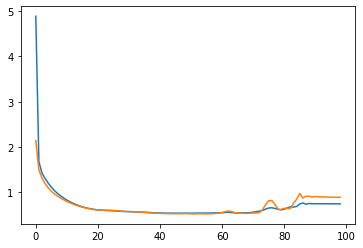

In [47]:
plt.plot(train_loss_history[1:])
plt.plot(test_loss_history[1:])
#plt.savefig()

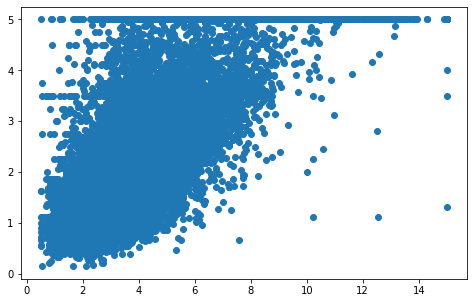

In [68]:
y_smooth = pd.Series(y_train).rolling(18).mean()
plt.figure(figsize=(8,5))
plt.scatter(X_train[:,0], y_train)

In [69]:
f_out_tr.shape

(16512, 8, 1)

In [19]:
def load_model(model_dir, run_id):
    model = torch.load(f'{model_dir}model_{run_id}.pth')
    return model

In [20]:
# do one forward pass
model_dir = "./models/SNAM/"
run_id = '84_ch'
pretrained_model = load_model(model_dir, run_id)

AttributeError: Can't get attribute 'NAM' on <module '__main__'>

In [ ]:
# do one forward pass
for idx1, (inputs, targets) in tqdm(enumerate(trainloader)): 
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs, f_out_tr_temp = model(inputs)[0],model(inputs)[1].detach().cpu().numpy()

In [27]:
feature_names = ch_data.feature_names
res_path = './results'

# Plot shape functions
def plot_CH_shape_functions(X, y, f_tr, feature_names, res_path=res_path):
    features = y
    for i in range(f_tr.shape[1]):
        if i < y.shape[0]:
            f_i = y
        else: f_i = np.zeros_like(X[:, i])
        c_i=np.mean(f_tr[:,[i]]-f_i)

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))

    i = 0
    for row in axes:
        for col in row:
            if i < y.shape[0]:
                f_i = y
            else: 
                f_i = np.zeros_like(X[:, i])
            c_i=np.mean(f_tr[:,[i]]-f_i) 
            col.scatter(X[:, i], f_tr[:, [i]]-c_i, label='SNAM')
            #col.scatter(X_train, features[i](X_train))
            if i == 8:
                col.legend(fontsize='15')
            col.xaxis.set_tick_params(labelsize=15)
            col.yaxis.set_tick_params(labelsize=15)
            col.set_xlabel(f'{feature_names[i]}', fontsize='20')
            col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
            i += 1

    fig.tight_layout()
    fig.savefig(res_path+'plot_CH_snam.png', bbox_inches='tight')
    plt.show()        

In [30]:
print(X_train.shape, " - ", f_out_tr.shape)

(16512, 8)  -  (16512, 8, 1)


In [29]:
print(X_test.shape, " - ", f_out_te.shape)

(4128, 8)  -  (1024, 1)


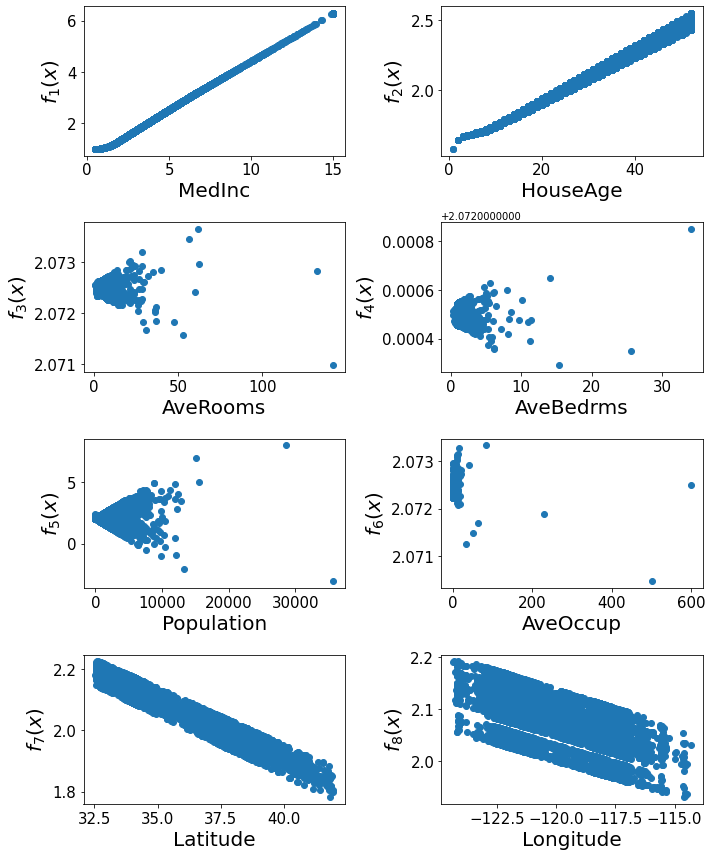

In [48]:
plot_CH_shape_functions(X_train, y_train, f_out_tr, feature_names)

Notice:
Cannot reproduce plots from paper on California Housing dataset.
-> Something might be off with the plot function...